<a href="https://colab.research.google.com/github/AleWstyd/GAN-emotional-stimuli/blob/main/Conditional_GAN_AffectNet_with_transform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Script to get the best GPU on colab

In [ ]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 
if  gpu.memoryUtil != 0:
  !kill -9 -1

  Created wheel for gputil: filename=GPUtil-1.4.0-cp37-none-any.whl size=7411 sha256=db9b2977f3c8d4be85323e1479150e598a46376d978a2d2f6fc52632d3cf7b90
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.8 GB  | Proc size: 118.6 MB
GPU RAM Free: 15109MB | Used: 0MB | Util   0% | Total 15109MB


In [ ]:
!unzip /content/drive/MyDrive/AffectNetMagisterka/AffectNetData.zip

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
  inflating: content/AffectNetData/1/19267.npy  
  inflating: content/AffectNetData/1/49878.npy  
  inflating: content/AffectNetData/1/20492.npy  
  inflating: content/AffectNetData/1/2778.npy  
  inflating: content/AffectNetData/1/7857.npy  
  inflating: content/AffectNetData/1/29430.npy  
  inflating: content/AffectNetData/1/30679.npy  
  inflating: content/AffectNetData/1/4988.npy  
  inflating: content/AffectNetData/1/12213.npy  
  inflating: content/AffectNetData/1/15893.npy  
  inflating: content/AffectNetData/1/3083.npy  
  inflating: content/AffectNetData/1/26127.npy  
  inflating: content/AffectNetData/1/17210.npy  
  inflating: content/AffectNetData/1/24463.npy  
  inflating: content/AffectNetData/1/25458.npy  
  inflating: content/AffectNetData/1/8880.npy  
  inflating: content/AffectNetData/1/40262.npy  
  inflating: content/AffectNetData/1/9362.npy  
  inflating: content/AffectNetData/1/47849.npy  
  inflatin

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from tensorflow.keras.datasets.fashion_mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout
from tensorflow.keras.models import load_model, Model, Sequential, save_model
from tensorflow.keras.layers import Input, Embedding, Concatenate, BatchNormalization
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle

In [ ]:
def generate_length_dict(folder_path):
  label_lengths_dict = dict()
  for folder in os.listdir(folder_path):
    label_lengths_dict[folder] = len(os.listdir(folder_path + '/' + folder))
  return label_lengths_dict

In [ ]:
def generate_real_samples(folder_path, n_samples,label_lengths_dict, idg, n_classes=7):
    X = []
    labels = np.empty((0))
    samples_per_class = int(n_samples/n_classes)
    for label in range(n_classes):
      current_path = folder_path + '/' + str(label)
      n_files = label_lengths_dict[str(label)]
      # get images
      images = np.random.randint(0, n_files, samples_per_class)
      for image in images:
        random_image = np.load(current_path + '/' + str(image) + '.npy')
        random_image = apply_random_transform(idg, random_image)
        X.append(random_image)
      # create labels
      y = np.ones(samples_per_class) * label
      labels = np.concatenate((labels, y),axis=0)
    X = np.asarray(X)
    labels = labels.astype(int)
    X,labels = shuffle(X,labels)
    # generate class labels
    y = np.ones((n_samples, 1))
    return [X,labels], y

In [ ]:
def apply_random_transform(idgObject, X):
  # get random transform dictionary
  random_tranform_dict = idgObject.get_random_transform(X.shape)
  # remove unneccesary keys
  for key in ['brightness', 'channel_shift_intensity', 'shear']:
    random_tranform_dict.pop(key)
  # get one random transformation
  entry_list = list(random_tranform_dict.items())
  random_el = random.choice(entry_list)
  one_random_transform = {random_el[0] : random_el[1]}
  # apply transform to the image
  X = idg.apply_transform(X,one_random_transform)
  return X

In [ ]:
def generate_latent_points(latent_dim, n_samples, n_classes=7):
    x_input = np.empty((0,latent_dim))
    labels = np.empty((0))
    samples_per_class = int(n_samples/n_classes)
    for class_y in range(n_classes):
      # generate points in the latent space
      x = np.random.randn(latent_dim * samples_per_class)
      # reshape into a batch of inputs for the network
      x = x.reshape(samples_per_class, latent_dim)
      x_input = np.concatenate((x_input, x),axis=0)
      # generate labels
      y = np.ones(samples_per_class) * class_y
      labels = np.concatenate((labels, y),axis=0)
    x_input, labels = shuffle(x_input, labels)
    labels = labels.astype(int)
    return [x_input,labels]

In [ ]:
def generate_fake_samples(generator, latent_dim, n_samples, idg, n_classes=7):
    # generate points in latent space
    x_input, labels = generate_latent_points(latent_dim, n_samples, n_classes)
    # predict outputs
    images = generator.predict([x_input,labels])
    transformed_images = []
    for image in images:
      transformed_image = apply_random_transform(idg, image)
      transformed_images.append(transformed_image)
    transformed_images = np.asarray(transformed_images)
    # create class labels
    y = np.zeros((n_samples, 1))
    return [transformed_images,labels], y

**Create Models**

In [ ]:
def define_discriminator(in_shape=(80, 80, 3), n_classes=7):
    in_label = Input(shape=(1,))
    li = Embedding(n_classes, 50)(in_label)
    # scale to image size
    n_nodes = in_shape[0] * in_shape[1]
    li = Dense(n_nodes)(li)
    li = Reshape((in_shape[0],in_shape[1],1))(li)
    # image input
    in_image = Input(shape=in_shape)
    # concatenate image and label inputs
    concat = Concatenate()([in_image,li])
    # create a RandomNormal weight initializer for next layers
    # init = RandomNormal(mean=0.0, stddev=0.02)
    # 80x80
    fe = Conv2D(128, (5,5), padding='same')(concat)
    # fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # downsample to 40x40
    fe = Conv2D(128, (5,5), strides=(2,2), padding='same')(fe)
    # fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # downsample to 20x20
    fe = Conv2D(128, (5,5), strides=(2,2), padding='same')(fe)
    # fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # downsample to 10x10
    fe = Conv2D(128, (5,5), strides=(2,2), padding='same')(fe)
    # fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # downsample to 5x5
    fe = Conv2D(128, (5,5), strides=(2,2), padding='same')(fe)
    # fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # classifier
    fe = Flatten()(fe)
    fe = Dropout(0.4)(fe)
    out_layer = Dense(1, activation='sigmoid')(fe)
    model = Model(([in_image,in_label]),out_layer)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [ ]:
# define the standalone generator model
def define_generator(latent_dim, n_classes=7):
    in_label = Input(shape=(1,))
    li = Embedding(n_classes, 50)(in_label)
    n_nodes = 5 * 5
    li = Dense(n_nodes)(li)
    li = Reshape((5,5,1))(li)
    # latent space vector input
    lat_input = Input(shape=(latent_dim,))
    n_nodes = 128 * 5 * 5
    gen = Dense(n_nodes, input_dim=latent_dim)(lat_input)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((5, 5, 128))(gen)
    # merge latent space vector and label inputs
    concat = Concatenate()([gen,li])
    # create a RandomNormal weight initializer for next layers
    # init = RandomNormal(mean=0.0, stddev=0.02)
    # upsample to 10x10
    fe = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(concat)
    # fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # upsample to 20x20
    fe = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(fe)
    # fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # upsample to 40x40
    fe = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(fe)
    # fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # upsample to 80x80
    fe = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(fe)
    # fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # generate
    gen = Conv2D(3, (5,5), activation='tanh', padding='same')(fe)
    model = Model(([lat_input,in_label]),gen)
    return model

In [ ]:
def define_gan(generator, discriminator):
  discriminator.trainable = False
  gen_lat_input, gen_label_input = generator.input
  gen_output = generator.output
  gan_output = discriminator([gen_output,gen_label_input])
  model = Model(([gen_lat_input, gen_label_input]),gan_output)
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

**Train**

In [ ]:
def save_plot(examples, epoch, n_classes=7, n_samples_per_class=10):
  # scale from [-1,1] to [0,1]
  examples = (examples + 1) / 2.0
  for i in range(n_classes * n_samples_per_class):
    plt.subplot(n_classes, n_samples_per_class, 1 + i)
    plt.axis('off')
    plt.imshow(examples[i])
  filename = 'generated_plot_e%03d.png' % (epoch+1)
  plt.savefig(filename)
  plt.close()

In [ ]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, folder_path, latent_dim,label_lengths_dict, idg, n_samples=70, n_classes=7):
  # prepare real samples
  [X_real, labels_real], y_real = generate_real_samples(folder_path, n_samples,label_lengths_dict, idg, n_classes)
  # evaluate discriminator on real examples
  _, acc_real = d_model.evaluate([X_real, labels_real], y_real, verbose=0)
  # prepare fake examples
  [x_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, n_samples, idg, n_classes)
  # evaluate discriminator on fake examples
  _, acc_fake = d_model.evaluate([x_fake, labels_fake], y_fake, verbose=0)
  # summarize discriminator performance
  print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
  # save plot
  save_plot(x_fake, epoch)
  # save the generator model tile file
  filename = 'generator_model_%03d.h5' % (epoch+1)
  g_model.save(filename)

In [ ]:
def train(g_model, d_model, gan_model, folder_path, latent_dim, idg,start_epoch=0, n_epochs=100, n_batch=128, n_classes=7):
  label_lengths_dict = generate_length_dict(folder_path)
  n_files = sum(list(label_lengths_dict.values()))
  bat_per_epo = 896 # 896????
  half_batch = int(n_batch / 2)
	# manually enumerate epochs
  for i in range(n_epochs):
    # enumerate batches over the training set
    for j in range(bat_per_epo):
      # get randomly selected 'real' samples
      [X_real, labels_real], y_real = generate_real_samples(folder_path, half_batch,label_lengths_dict, idg, n_classes)
      # update discriminator model weights
      d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
      # generate 'fake' examples
      [X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch, idg, n_classes)
      # update discriminator model weights
      d_loss2, _ = d_model.train_on_batch([X_fake, labels_fake], y_fake)
      # prepare points in latent space as input for the generator
      X_gan,gan_labels = generate_latent_points(latent_dim, n_batch, n_classes)
      # create inverted labels for the fake samples
      y_gan = np.ones((n_batch, 1))
      # update the generator via the discriminator's error
      g_loss = gan_model.train_on_batch([X_gan,gan_labels], y_gan)
      # summarize loss on this batch
      print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
        (i+1 + start_epoch, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
    if (i+1 + start_epoch) % 5 == 0:
      summarize_performance(i + start_epoch, g_model, d_model, folder_path, latent_dim,label_lengths_dict, idg, n_classes=n_classes)
      filename = 'gan_model_%03d.h5' % (i+1+start_epoch)
      gan_model.save(filename)
      filename = 'disc_model_%03d.h5' % (i+1+start_epoch)
      discriminator.save(filename)

**Main**

In [ ]:
folder_path = '/content/content/AffectNetData'

In [ ]:
# size of the latent space
latent_dim = 100

In [ ]:
n_classes=7

In [ ]:
idg = ImageDataGenerator(rotation_range=90,
                        zoom_range = [0.7,1.3],
                        height_shift_range=0.2,
                        width_shift_range=0.2,
                        horizontal_flip=True,
                        vertical_flip = True)

In [ ]:
n_batch = 64* n_classes

In [ ]:
# train model
generator = define_generator(latent_dim,n_classes)
discriminator = define_discriminator(n_classes= n_classes)
gan_model = define_gan(generator, discriminator)

In [ ]:
generator.summary()
discriminator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 3200)         323200      input_2[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 50)        350         input_1[0][0]                    
______________________________________________________________________________________________

In [ ]:
train(generator, discriminator, gan_model, folder_path, latent_dim, idg,start_epoch=0, n_epochs=100,n_batch=n_batch, n_classes=n_classes)

>1, 1/896, d1=0.000, d2=0.493 g=8.508
>1, 2/896, d1=0.000, d2=0.015 g=10.986
>1, 3/896, d1=0.000, d2=0.156 g=26.299
>1, 4/896, d1=0.101, d2=0.000 g=15.152
>1, 5/896, d1=0.000, d2=1.404 g=21.449
>1, 6/896, d1=0.038, d2=0.000 g=24.628
>1, 7/896, d1=0.137, d2=0.000 g=16.774
>1, 8/896, d1=0.122, d2=0.000 g=9.609
>1, 9/896, d1=0.004, d2=0.176 g=11.932
>1, 10/896, d1=0.058, d2=0.000 g=10.743
>1, 11/896, d1=0.027, d2=0.601 g=49.704
>1, 12/896, d1=17.687, d2=0.326 g=0.361
>1, 13/896, d1=0.000, d2=1.368 g=1.586
>1, 14/896, d1=0.309, d2=0.347 g=1.219
>1, 15/896, d1=0.019, d2=0.313 g=1.471
>1, 16/896, d1=0.042, d2=0.231 g=1.818
>1, 17/896, d1=0.013, d2=0.154 g=2.297
>1, 18/896, d1=0.064, d2=0.154 g=2.031
>1, 19/896, d1=0.001, d2=0.129 g=2.552
>1, 20/896, d1=0.005, d2=0.071 g=3.160
>1, 21/896, d1=0.050, d2=0.062 g=2.945
>1, 22/896, d1=0.001, d2=0.057 g=3.342
>1, 23/896, d1=0.003, d2=0.036 g=3.723
>1, 24/896, d1=0.001, d2=0.026 g=4.020
>1, 25/896, d1=0.024, d2=0.035 g=3.426
>1, 26/896, d1=0.000, d2

In [ ]:
def save(gan, generator, discriminator):
    discriminator.trainable = False
    gan.save('gan.h5')
    discriminator.trainable = True
    generator.save('generator.h5')
    discriminator.save('discriminator.h5')

In [ ]:
def load():
    discriminator = load_model('discriminator.h5')
    generator = load_model('generator.h5')
    gan = load_model('gan.h5')
    return gan, generator, discriminator

In [ ]:
save(gan_model,generator, discriminator)

In [ ]:
gan,gen,disc = load()

In [ ]:
gan = load_model('/content/gan_model_005.h5')

In [ ]:
disc = load_model('/content/disc_model_005.h5')

In [ ]:
gen = load_model('/content/generator_model_005.h5')

In [ ]:
gan = define_gan(gen, disc)

ValueError: ignored

In [ ]:
train(gen, disc, gan, folder_path, latent_dim, idg, n_epochs=100,n_batch=n_batch, n_classes=n_classes)

>1, 1/896, d1=0.000, d2=0.468 g=0.304
>1, 2/896, d1=0.000, d2=0.000 g=0.000


KeyboardInterrupt: ignored

In [ ]:
digit = 0

In [ ]:
latent_points, labels = generate_latent_points(100, 1)
labels = np.array([digit])
X = generator.predict([latent_points,labels])
X = (X +1.0) /2.0
plt.imshow(X[0])

ValueError: ignored

In [ ]:
def plot_images(examples, n_classes, n_samples_per_class):
  examples = (examples +1.0) /2.0
  for i in range(n_classes * n_samples_per_class):
      plt.subplot(n_classes, n_samples_per_class, 1 + i)
      plt.axis('off')
      plt.imshow(examples[i])

In [ ]:
label_lengths_dict = generate_length_dict(folder_path)
[X_real,y_real],y_fake = generate_real_samples(folder_path, 7,label_lengths_dict, idg, n_classes)

In [ ]:
X_real.shape

(7, 80, 80, 3)

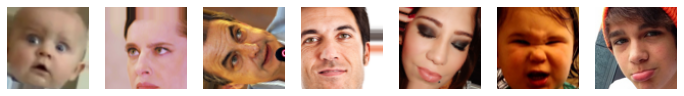

In [ ]:
label_lengths_dict = generate_length_dict(folder_path)
[X_real,y_real],y_fake = generate_real_samples(folder_path, 7,label_lengths_dict, idg, n_classes)
plt.figure(figsize=(12,8))
plot_images(X_real,1,7)

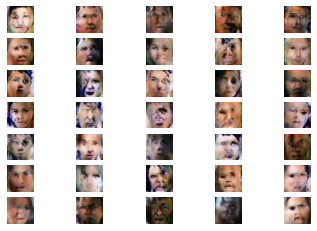

In [ ]:
latent_points, labels = generate_latent_points(100, 35)
# labels = np.append(np.zeros(7), np.ones(7))
X = generator.predict([latent_points,labels])
X = (X +1.0) /2.0
plot_images(X, 7,5)

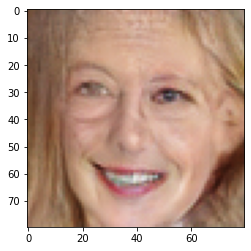

In [ ]:
plt.imshow(X[12])